In [211]:
import numpy as np
import seaborn as sns
from scipy import stats, signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime as dt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [237]:
def buildDataframe(countyString):
    #load data, renames columns, converts timestamps to datetime, & sets datetime as index
    dfMax = pd.read_csv("RawData/"+countyString+"-tmax-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfMax['Date'] = pd.to_datetime(dfMax['Date'], yearfirst = True, format = "%Y%m")
    dfMax = dfMax.rename(columns={dfMax.columns[1]:'MaxTempF'})
    dfMax = dfMax.rename(columns={dfMax.columns[2]:'MaxAnomalyF'})
    dfMax = dfMax.set_index(dfMax['Date'])
    del dfMax['Date']

    dfMin = pd.read_csv("RawData/"+countyString+"-tmin-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfMin['Date'] = pd.to_datetime(dfMin['Date'], yearfirst = True, format = "%Y%m")
    dfMin = dfMin.rename(columns={dfMin.columns[1]:'MinTempF'})
    dfMin = dfMin.rename(columns={dfMin.columns[2]:'MinAnomalyF'})
    dfMin = dfMin.set_index(dfMin['Date'])
    del dfMin['Date']

    dfAvg = pd.read_csv("RawData/"+countyString+"-tavg-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfAvg['Date'] = pd.to_datetime(dfAvg['Date'], yearfirst = True, format = "%Y%m")
    dfAvg = dfAvg.rename(columns={dfAvg.columns[1]:'AvgTempF'})
    dfAvg = dfAvg.rename(columns={dfAvg.columns[2]:'AvgAnomalyF'})
    dfAvg = dfAvg.set_index(dfAvg['Date'])
    del dfAvg['Date']

    dfPrecip = pd.read_csv("RawData/"+countyString+"-pcp-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfPrecip['Date'] = pd.to_datetime(dfPrecip['Date'], yearfirst = True, format = "%Y%m")
    dfPrecip = dfPrecip.rename(columns={dfPrecip.columns[1]:'PrecipitationIn'})
    dfPrecip = dfPrecip.rename(columns={dfPrecip.columns[2]:'PrecipAnomalyIn'})
    dfPrecip = dfPrecip.set_index(dfPrecip['Date'])
    del dfPrecip['Date']

    df = pd.concat([dfMax, dfMin, dfPrecip, dfAvg], axis=1)
    return df

def scaleData(df):
    values = df.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled

def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def split_reshapeData(reframed_data, training_months):
    values = reframed_data.values
    train = values[:training_months, :]
    test = values[training_months:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-2], train[:, -2]
    test_X, test_y = test[:, :-2], test[:, -2]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y

def testCounty(test_county):
    test = test_county.values
    test_X, test_y = test[:, :-2], test[:, -2]
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
    return test_X, test_y

def trainModel(train_X, train_y, test_X, test_y):
    model = keras.models.Sequential()
    model.add(layers.LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(layers.Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error',
              tf.keras.metrics.RootMeanSquaredError(),
               'mean_absolute_percentage_error',
               'mean_squared_logarithmic_error'])
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    return model, history

def predictModel(model, model_name, test_county, county_name, pred_months):
    scaled = scaleData(test_county)
    reframed = series_to_supervised(scaled, pred_months, 1)
    test_X, test_y = testCounty(reframed)
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])
    inv_yhat = np.concatenate((yhat, test_X), axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_y)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print(model_name, ' - ', county_name, 'Test RMSE: %.3f' % rmse)

In [233]:
dfWayne = buildDataframe('MI-163')
dfCook = buildDataframe('IL-031')
dfNueces = buildDataframe('TX-355')
dfNueces

,MaxTempF,MaxAnomalyF,MinTempF,MinAnomalyF,PrecipitationIn,PrecipAnomalyIn,AvgTempF,AvgAnomalyF
Date,,,,,,,,
1895-01-01,68.3,2.8,44.1,-1.6,1.14,-0.35,56.2,0.6
1895-02-01,56.3,-12.8,39.0,-9.7,3.11,1.46,47.7,-11.2
1895-03-01,73.2,-1.6,54.2,-1.1,0.59,-0.98,63.7,-1.3
1895-04-01,84.3,3.2,58.2,-4.2,1.88,-0.03,71.2,-0.6
1895-05-01,84.2,-1.8,65.6,-3.2,5.52,2.17,74.9,-2.5
...,...,...,...,...,...,...,...,...
2021-06-01,92.0,1.1,74.8,1.3,5.41,2.36,83.4,1.2
2021-07-01,92.2,-1.1,75.3,0.4,8.20,6.01,83.8,-0.3
2021-08-01,95.1,1.1,76.0,1.3,1.68,-0.85,85.6,1.2


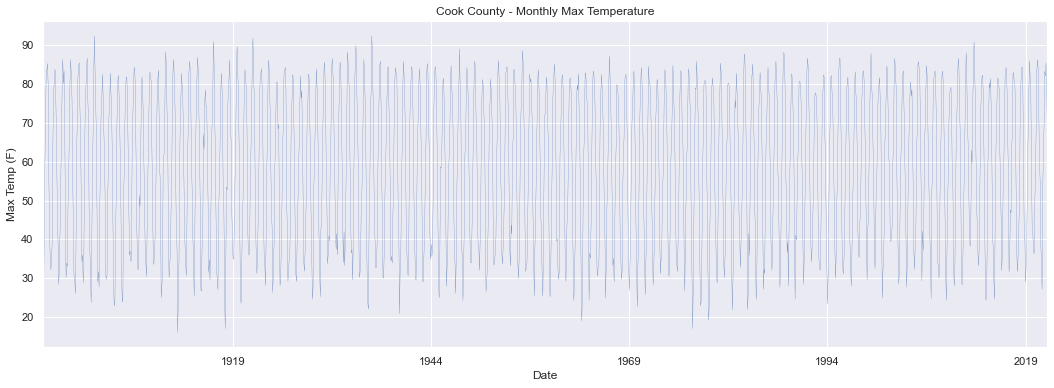

In [115]:
sns.set(rc={'figure.figsize':(18, 6)})
#plots raw data
ax = dfCook['MaxTempF'].plot(linewidth=0.25)
ax.set_ylabel('Max Temp (F)')
ax.set_title('Cook County - Monthly Max Temperature')
plt.show()

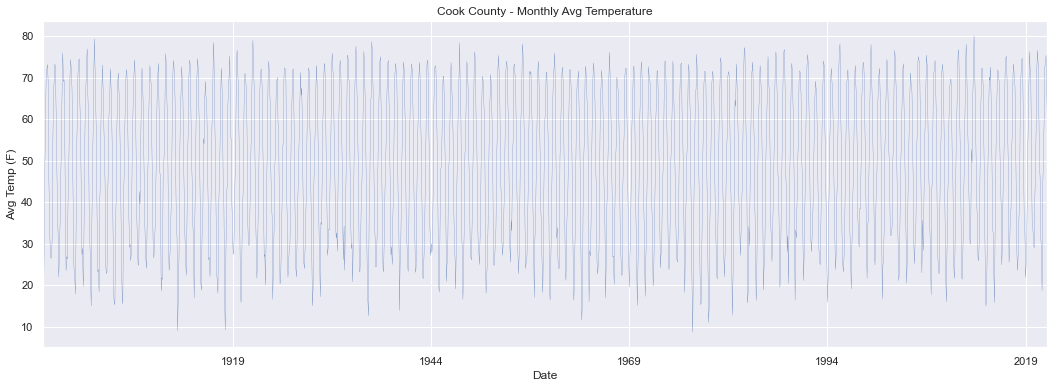

In [117]:
#plots raw data
ax = dfCook['AvgTempF'].plot(linewidth=0.25)
ax.set_ylabel('Avg Temp (F)')
ax.set_title('Cook County - Monthly Avg Temperature')
plt.show()

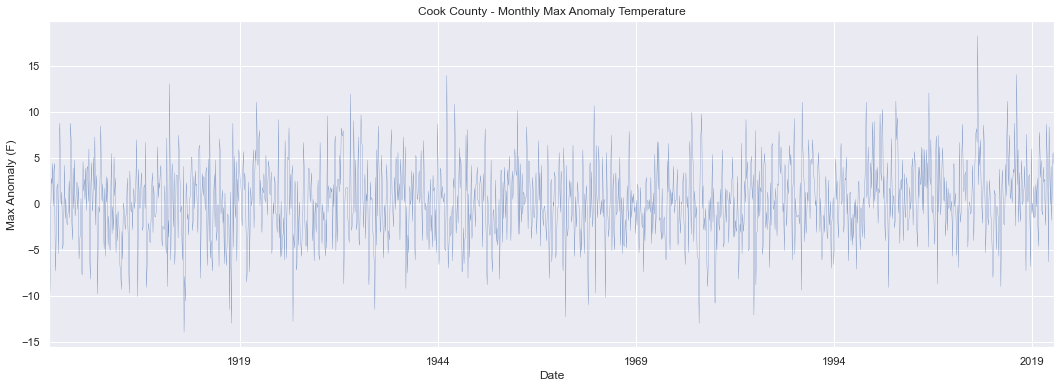

In [118]:
#plots raw data
ax = dfCook['MaxAnomalyF'].plot(linewidth=0.25)
ax.set_ylabel('Max Anomaly (F)')
ax.set_title('Cook County - Monthly Max Anomaly Temperature')
plt.show()

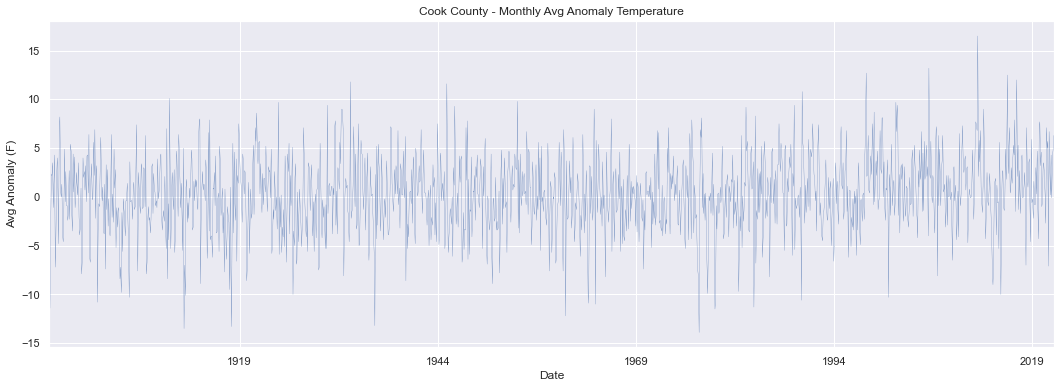

In [119]:
#plots raw data
ax = dfCook['AvgAnomalyF'].plot(linewidth=0.25)
ax.set_ylabel('Avg Anomaly (F)')
ax.set_title('Cook County - Monthly Avg Anomaly Temperature')
plt.show()

In [120]:
df_CookSummer = dfCook[dfCook.index.month.isin([6,7,8])]
df_CookSummer

,MaxTempF,MaxAnomalyF,MinTempF,MinAnomalyF,AvgTempF,AvgAnomalyF,PrecipitationIn,PrecipAnomalyIn
Date,,,,,,,,
1895-06-01,83.6,4.4,60.1,2.7,71.8,3.5,1.46,-2.51
1895-07-01,83.7,-0.2,60.6,-2.1,72.2,-1.1,3.60,0.11
1895-08-01,85.3,3.7,61.1,-0.2,73.2,1.8,3.74,0.27
1896-06-01,80.0,0.8,58.3,0.9,69.1,0.8,3.07,-0.90
1896-07-01,83.8,-0.1,62.8,0.1,73.3,0.0,5.11,1.62
...,...,...,...,...,...,...,...,...
2020-07-01,86.3,2.4,66.8,4.1,76.6,3.3,3.17,-0.32
2020-08-01,84.3,2.7,62.6,1.3,73.5,2.1,1.24,-2.23
2021-06-01,83.3,4.1,61.9,4.5,72.6,4.3,6.80,2.83


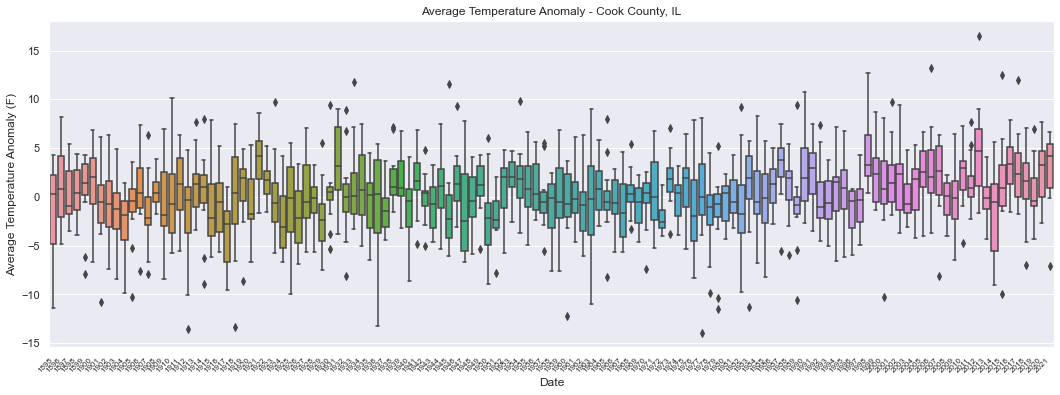

In [121]:
ax = sns.boxplot(data=dfCook, x=dfCook.index.year, y='AvgAnomalyF')
ax.set_ylabel('Average Temperature Anomaly (F)')
ax.set_title('Average Temperature Anomaly - Cook County, IL')
#x_dates = df_CookTemp.index.year.dt.strftime('%Y').sort_values().unique()
ax.set_xticklabels(labels=dfCook.index.year.sort_values().unique(), fontdict = {'fontsize':8}, rotation=45, ha='right')
plt.show()

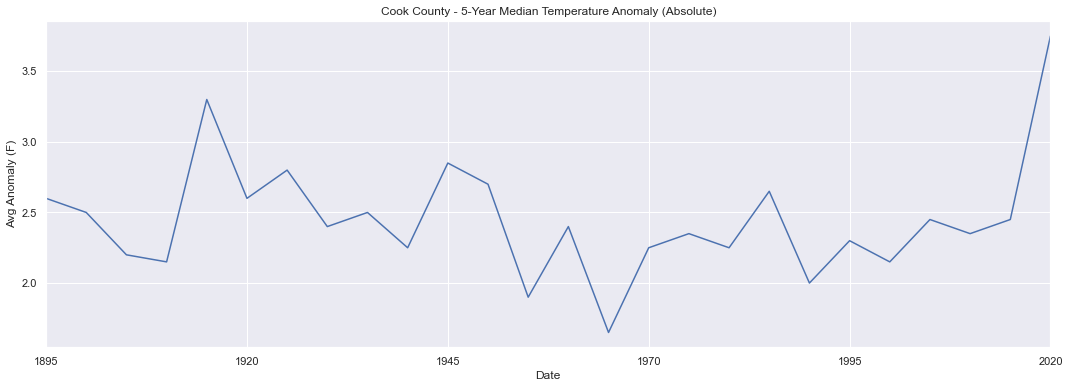

In [122]:
absAnomaly = dfCook.abs()
absAnomaly = absAnomaly.resample('5YS').median()
ax = absAnomaly['AvgAnomalyF'].plot()
ax.set_ylabel('Avg Anomaly (F)')
ax.set_title('Cook County - 5-Year Median Temperature Anomaly (Absolute)')
plt.show()

Epoch 1/50
17/17 - 1s - loss: 0.4050 - mean_squared_error: 0.2178 - root_mean_squared_error: 0.4667 - mean_absolute_percentage_error: 73958.6094 - mean_squared_logarithmic_error: 0.1076 - val_loss: 0.2497 - val_mean_squared_error: 0.0896 - val_root_mean_squared_error: 0.2993 - val_mean_absolute_percentage_error: 38.3614 - val_mean_squared_logarithmic_error: 0.0355
Epoch 2/50
17/17 - 0s - loss: 0.1682 - mean_squared_error: 0.0428 - root_mean_squared_error: 0.2068 - mean_absolute_percentage_error: 161699.5625 - mean_squared_logarithmic_error: 0.0174 - val_loss: 0.1250 - val_mean_squared_error: 0.0244 - val_root_mean_squared_error: 0.1563 - val_mean_absolute_percentage_error: 38.1356 - val_mean_squared_logarithmic_error: 0.0117
Epoch 3/50
17/17 - 0s - loss: 0.1239 - mean_squared_error: 0.0243 - root_mean_squared_error: 0.1560 - mean_absolute_percentage_error: 167785.0625 - mean_squared_logarithmic_error: 0.0121 - val_loss: 0.1094 - val_mean_squared_error: 0.0183 - val_root_mean_squared_er

Epoch 23/50
17/17 - 0s - loss: 0.0053 - mean_squared_error: 5.4099e-05 - root_mean_squared_error: 0.0074 - mean_absolute_percentage_error: 35986.0586 - mean_squared_logarithmic_error: 3.3515e-05 - val_loss: 0.0058 - val_mean_squared_error: 5.0792e-05 - val_root_mean_squared_error: 0.0071 - val_mean_absolute_percentage_error: 1.5117 - val_mean_squared_logarithmic_error: 2.4300e-05
Epoch 24/50
17/17 - 0s - loss: 0.0053 - mean_squared_error: 5.0562e-05 - root_mean_squared_error: 0.0071 - mean_absolute_percentage_error: 33272.1016 - mean_squared_logarithmic_error: 3.0315e-05 - val_loss: 0.0044 - val_mean_squared_error: 3.3105e-05 - val_root_mean_squared_error: 0.0058 - val_mean_absolute_percentage_error: 1.2463 - val_mean_squared_logarithmic_error: 1.7462e-05
Epoch 25/50
17/17 - 0s - loss: 0.0048 - mean_squared_error: 4.3242e-05 - root_mean_squared_error: 0.0066 - mean_absolute_percentage_error: 32896.1562 - mean_squared_logarithmic_error: 2.6372e-05 - val_loss: 0.0043 - val_mean_squared_e

Epoch 45/50
17/17 - 0s - loss: 0.0025 - mean_squared_error: 1.1735e-05 - root_mean_squared_error: 0.0034 - mean_absolute_percentage_error: 19151.0879 - mean_squared_logarithmic_error: 6.9070e-06 - val_loss: 0.0023 - val_mean_squared_error: 9.4181e-06 - val_root_mean_squared_error: 0.0031 - val_mean_absolute_percentage_error: 0.6273 - val_mean_squared_logarithmic_error: 4.6633e-06
Epoch 46/50
17/17 - 0s - loss: 0.0025 - mean_squared_error: 1.1144e-05 - root_mean_squared_error: 0.0033 - mean_absolute_percentage_error: 18532.1055 - mean_squared_logarithmic_error: 6.5311e-06 - val_loss: 0.0025 - val_mean_squared_error: 1.0968e-05 - val_root_mean_squared_error: 0.0033 - val_mean_absolute_percentage_error: 0.6493 - val_mean_squared_logarithmic_error: 5.2086e-06
Epoch 47/50
17/17 - 0s - loss: 0.0027 - mean_squared_error: 1.2603e-05 - root_mean_squared_error: 0.0036 - mean_absolute_percentage_error: 17687.0801 - mean_squared_logarithmic_error: 6.8366e-06 - val_loss: 0.0024 - val_mean_squared_e

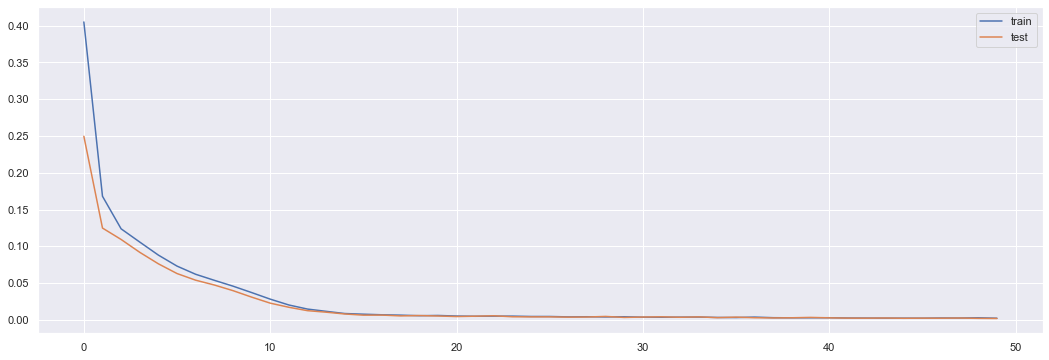

In [238]:
training_months = 12 * 100
#train model on Cook County
model_name = 'Cook, 1-month prediction'
pred_months = 1
scaledCook = scaleData(dfCook)
reframed = series_to_supervised(scaledCook, pred_months, 1)
train_X1m, train_y1m, test_X1m, test_y1m = split_reshapeData(reframed, training_months)
model1m, history1m = trainModel(train_X1m, train_y1m, test_X1m, test_y1m)
plt.plot(history1m.history['loss'], label='train')
plt.plot(history1m.history['val_loss'], label='test')
plt.legend()
plt.show()

In [239]:
yhat = model1m.predict(test_X1m)
test_X1m = test_X1m.reshape((test_X1m.shape[0], test_X1m.shape[2]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])
inv_yhat = np.concatenate((yhat, test_X1m), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1m = test_y1m.reshape((len(test_y1m), 1))
inv_y = np.concatenate((test_y1m, test_X1m[:, 1:]), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_y)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(model_name, ' - Test RMSE: %.3f' % rmse)

Cook, 1-month prediction  - Test RMSE: 0.004


In [240]:
predictModel(model1m, model_name, dfNueces, 'Nueces', pred_months)
predictModel(model1m, model_name, dfWayne, 'Wayne', pred_months)

Cook, 1-month prediction  -  Nueces Test RMSE: 0.037
Cook, 1-month prediction  -  Wayne Test RMSE: 0.013


Epoch 1/50
17/17 - 1s - loss: 0.3746 - mean_squared_error: 0.2064 - root_mean_squared_error: 0.4543 - mean_absolute_percentage_error: 178192.5625 - mean_squared_logarithmic_error: 0.1001 - val_loss: 0.1707 - val_mean_squared_error: 0.0387 - val_root_mean_squared_error: 0.1967 - val_mean_absolute_percentage_error: 44.1505 - val_mean_squared_logarithmic_error: 0.0167
Epoch 2/50
17/17 - 0s - loss: 0.1821 - mean_squared_error: 0.0498 - root_mean_squared_error: 0.2232 - mean_absolute_percentage_error: 271763.8750 - mean_squared_logarithmic_error: 0.0231 - val_loss: 0.1576 - val_mean_squared_error: 0.0389 - val_root_mean_squared_error: 0.1972 - val_mean_absolute_percentage_error: 48.9185 - val_mean_squared_logarithmic_error: 0.0180
Epoch 3/50
17/17 - 0s - loss: 0.1507 - mean_squared_error: 0.0307 - root_mean_squared_error: 0.1751 - mean_absolute_percentage_error: 193568.0781 - mean_squared_logarithmic_error: 0.0142 - val_loss: 0.1247 - val_mean_squared_error: 0.0222 - val_root_mean_squared_e

Epoch 23/50
17/17 - 0s - loss: 0.0064 - mean_squared_error: 6.3976e-05 - root_mean_squared_error: 0.0080 - mean_absolute_percentage_error: 25104.9043 - mean_squared_logarithmic_error: 2.8392e-05 - val_loss: 0.0113 - val_mean_squared_error: 1.7544e-04 - val_root_mean_squared_error: 0.0132 - val_mean_absolute_percentage_error: 2.2962 - val_mean_squared_logarithmic_error: 6.4667e-05
Epoch 24/50
17/17 - 0s - loss: 0.0066 - mean_squared_error: 6.8749e-05 - root_mean_squared_error: 0.0083 - mean_absolute_percentage_error: 19161.1035 - mean_squared_logarithmic_error: 2.9615e-05 - val_loss: 0.0058 - val_mean_squared_error: 4.8190e-05 - val_root_mean_squared_error: 0.0069 - val_mean_absolute_percentage_error: 1.2712 - val_mean_squared_logarithmic_error: 2.0255e-05
Epoch 25/50
17/17 - 0s - loss: 0.0054 - mean_squared_error: 4.6281e-05 - root_mean_squared_error: 0.0068 - mean_absolute_percentage_error: 20390.7480 - mean_squared_logarithmic_error: 2.0574e-05 - val_loss: 0.0058 - val_mean_squared_e

Epoch 45/50
17/17 - 0s - loss: 0.0041 - mean_squared_error: 2.6004e-05 - root_mean_squared_error: 0.0051 - mean_absolute_percentage_error: 4644.7876 - mean_squared_logarithmic_error: 9.9622e-06 - val_loss: 0.0037 - val_mean_squared_error: 1.9382e-05 - val_root_mean_squared_error: 0.0044 - val_mean_absolute_percentage_error: 0.7339 - val_mean_squared_logarithmic_error: 7.6560e-06
Epoch 46/50
17/17 - 0s - loss: 0.0034 - mean_squared_error: 1.8142e-05 - root_mean_squared_error: 0.0043 - mean_absolute_percentage_error: 4563.6123 - mean_squared_logarithmic_error: 6.7986e-06 - val_loss: 0.0034 - val_mean_squared_error: 1.7800e-05 - val_root_mean_squared_error: 0.0042 - val_mean_absolute_percentage_error: 0.6781 - val_mean_squared_logarithmic_error: 6.8641e-06
Epoch 47/50
17/17 - 0s - loss: 0.0035 - mean_squared_error: 1.9338e-05 - root_mean_squared_error: 0.0044 - mean_absolute_percentage_error: 4288.8828 - mean_squared_logarithmic_error: 7.2566e-06 - val_loss: 0.0048 - val_mean_squared_erro

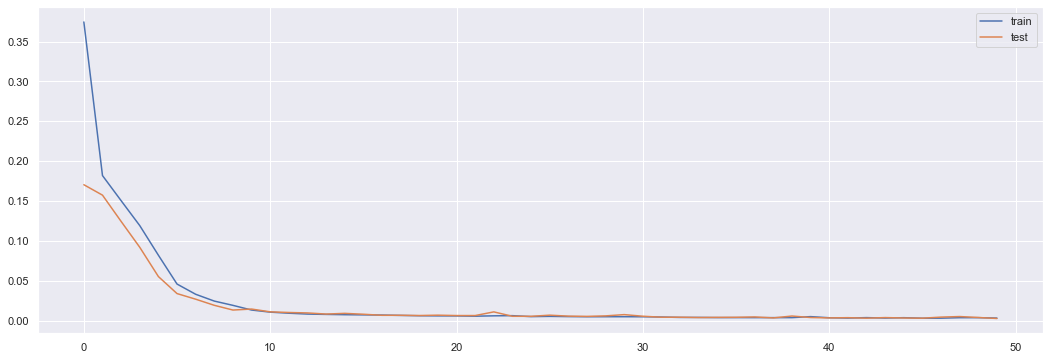

In [241]:
#train model on Cook County
model_name = 'Cook, 3-month prediction'
pred_months = 3
scaledCook = scaleData(dfCook)
reframed = series_to_supervised(scaledCook, pred_months, 1)
train_X, train_y, test_X, test_y = split_reshapeData(reframed, training_months)
model, history = trainModel(train_X, train_y, test_X, test_y)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [242]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])
inv_yhat = np.concatenate((yhat, test_X), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_y)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(model_name, ' - Test RMSE: %.3f' % rmse)

Cook, 3-month prediction  - Test RMSE: 0.004


In [243]:
predictModel(model, model_name, dfNueces, 'Nueces', pred_months)
predictModel(model, model_name, dfWayne, 'Wayne', pred_months)

Cook, 3-month prediction  -  Nueces Test RMSE: 0.029
Cook, 3-month prediction  -  Wayne Test RMSE: 0.012


Epoch 1/50
17/17 - 1s - loss: 0.2117 - mean_squared_error: 0.0709 - root_mean_squared_error: 0.2663 - mean_absolute_percentage_error: 336959.0938 - mean_squared_logarithmic_error: 0.0322 - val_loss: 0.1138 - val_mean_squared_error: 0.0177 - val_root_mean_squared_error: 0.1331 - val_mean_absolute_percentage_error: 24.6539 - val_mean_squared_logarithmic_error: 0.0069
Epoch 2/50
17/17 - 0s - loss: 0.0724 - mean_squared_error: 0.0084 - root_mean_squared_error: 0.0918 - mean_absolute_percentage_error: 83580.9297 - mean_squared_logarithmic_error: 0.0039 - val_loss: 0.0567 - val_mean_squared_error: 0.0047 - val_root_mean_squared_error: 0.0689 - val_mean_absolute_percentage_error: 12.5660 - val_mean_squared_logarithmic_error: 0.0019
Epoch 3/50
17/17 - 0s - loss: 0.0449 - mean_squared_error: 0.0033 - root_mean_squared_error: 0.0577 - mean_absolute_percentage_error: 114972.4297 - mean_squared_logarithmic_error: 0.0017 - val_loss: 0.0386 - val_mean_squared_error: 0.0026 - val_root_mean_squared_er

Epoch 23/50
17/17 - 0s - loss: 0.0073 - mean_squared_error: 8.4649e-05 - root_mean_squared_error: 0.0092 - mean_absolute_percentage_error: 16544.8125 - mean_squared_logarithmic_error: 3.7222e-05 - val_loss: 0.0061 - val_mean_squared_error: 5.4355e-05 - val_root_mean_squared_error: 0.0074 - val_mean_absolute_percentage_error: 1.3812 - val_mean_squared_logarithmic_error: 2.3600e-05
Epoch 24/50
17/17 - 0s - loss: 0.0058 - mean_squared_error: 5.2171e-05 - root_mean_squared_error: 0.0072 - mean_absolute_percentage_error: 6092.6353 - mean_squared_logarithmic_error: 2.3122e-05 - val_loss: 0.0054 - val_mean_squared_error: 4.4402e-05 - val_root_mean_squared_error: 0.0067 - val_mean_absolute_percentage_error: 1.1255 - val_mean_squared_logarithmic_error: 1.7650e-05
Epoch 25/50
17/17 - 0s - loss: 0.0056 - mean_squared_error: 4.8538e-05 - root_mean_squared_error: 0.0070 - mean_absolute_percentage_error: 10631.1611 - mean_squared_logarithmic_error: 2.1404e-05 - val_loss: 0.0061 - val_mean_squared_er

Epoch 45/50
17/17 - 0s - loss: 0.0080 - mean_squared_error: 8.4806e-05 - root_mean_squared_error: 0.0092 - mean_absolute_percentage_error: 10638.2646 - mean_squared_logarithmic_error: 3.7282e-05 - val_loss: 0.0093 - val_mean_squared_error: 1.0543e-04 - val_root_mean_squared_error: 0.0103 - val_mean_absolute_percentage_error: 2.2344 - val_mean_squared_logarithmic_error: 4.8318e-05
Epoch 46/50
17/17 - 0s - loss: 0.0078 - mean_squared_error: 7.3912e-05 - root_mean_squared_error: 0.0086 - mean_absolute_percentage_error: 8163.5527 - mean_squared_logarithmic_error: 3.2543e-05 - val_loss: 0.0066 - val_mean_squared_error: 5.8529e-05 - val_root_mean_squared_error: 0.0077 - val_mean_absolute_percentage_error: 1.5334 - val_mean_squared_logarithmic_error: 2.5999e-05
Epoch 47/50
17/17 - 0s - loss: 0.0050 - mean_squared_error: 3.8863e-05 - root_mean_squared_error: 0.0062 - mean_absolute_percentage_error: 7089.2275 - mean_squared_logarithmic_error: 1.7151e-05 - val_loss: 0.0054 - val_mean_squared_err

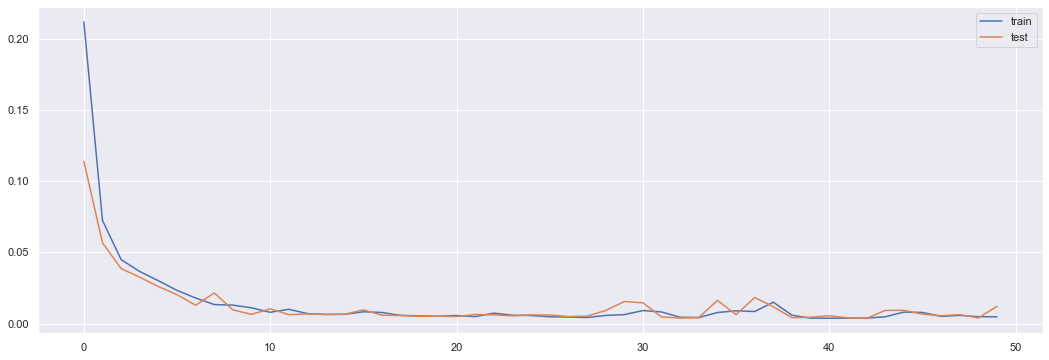

In [244]:
#train model on Cook County
model_name = 'Cook, 1-year prediction'
pred_months = 12
scaledCook = scaleData(dfCook)
reframed = series_to_supervised(scaledCook, pred_months, 1)
train_X, train_y, test_X, test_y = split_reshapeData(reframed, training_months)
model, history = trainModel(train_X, train_y, test_X, test_y)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [246]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])
inv_yhat = np.concatenate((yhat, test_X), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_y)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(model_name, ' - Test RMSE: %.3f' % rmse)

Cook, 1-year prediction  - Test RMSE: 0.015


In [245]:
predictModel(model, model_name, dfNueces, 'Nueces', pred_months)
predictModel(model, model_name, dfWayne, 'Wayne', pred_months)

Cook, 1-year prediction  -  Nueces Test RMSE: 0.056
Cook, 1-year prediction  -  Wayne Test RMSE: 0.014


Epoch 1/50
17/17 - 1s - loss: 0.1947 - mean_squared_error: 0.0664 - root_mean_squared_error: 0.2577 - mean_absolute_percentage_error: 439054.0000 - mean_squared_logarithmic_error: 0.0299 - val_loss: 0.1020 - val_mean_squared_error: 0.0137 - val_root_mean_squared_error: 0.1169 - val_mean_absolute_percentage_error: 19.8115 - val_mean_squared_logarithmic_error: 0.0054
Epoch 2/50
17/17 - 0s - loss: 0.0691 - mean_squared_error: 0.0074 - root_mean_squared_error: 0.0861 - mean_absolute_percentage_error: 204977.0938 - mean_squared_logarithmic_error: 0.0034 - val_loss: 0.0506 - val_mean_squared_error: 0.0042 - val_root_mean_squared_error: 0.0649 - val_mean_absolute_percentage_error: 14.0267 - val_mean_squared_logarithmic_error: 0.0021
Epoch 3/50
17/17 - 0s - loss: 0.0486 - mean_squared_error: 0.0039 - root_mean_squared_error: 0.0621 - mean_absolute_percentage_error: 186274.0000 - mean_squared_logarithmic_error: 0.0020 - val_loss: 0.0447 - val_mean_squared_error: 0.0034 - val_root_mean_squared_e

Epoch 23/50
17/17 - 0s - loss: 0.0144 - mean_squared_error: 3.1734e-04 - root_mean_squared_error: 0.0178 - mean_absolute_percentage_error: 32213.4062 - mean_squared_logarithmic_error: 1.4671e-04 - val_loss: 0.0427 - val_mean_squared_error: 0.0021 - val_root_mean_squared_error: 0.0458 - val_mean_absolute_percentage_error: 8.9633 - val_mean_squared_logarithmic_error: 8.9328e-04
Epoch 24/50
17/17 - 0s - loss: 0.0248 - mean_squared_error: 8.1786e-04 - root_mean_squared_error: 0.0286 - mean_absolute_percentage_error: 16474.1074 - mean_squared_logarithmic_error: 3.7525e-04 - val_loss: 0.0207 - val_mean_squared_error: 6.3241e-04 - val_root_mean_squared_error: 0.0251 - val_mean_absolute_percentage_error: 4.2114 - val_mean_squared_logarithmic_error: 2.4620e-04
Epoch 25/50
17/17 - 0s - loss: 0.0130 - mean_squared_error: 2.6815e-04 - root_mean_squared_error: 0.0164 - mean_absolute_percentage_error: 24525.2109 - mean_squared_logarithmic_error: 1.2011e-04 - val_loss: 0.0301 - val_mean_squared_error

Epoch 45/50
17/17 - 0s - loss: 0.0157 - mean_squared_error: 3.5094e-04 - root_mean_squared_error: 0.0187 - mean_absolute_percentage_error: 32077.7461 - mean_squared_logarithmic_error: 1.5646e-04 - val_loss: 0.0265 - val_mean_squared_error: 9.3613e-04 - val_root_mean_squared_error: 0.0306 - val_mean_absolute_percentage_error: 7.7929 - val_mean_squared_logarithmic_error: 4.9261e-04
Epoch 46/50
17/17 - 0s - loss: 0.0204 - mean_squared_error: 6.0096e-04 - root_mean_squared_error: 0.0245 - mean_absolute_percentage_error: 38711.1445 - mean_squared_logarithmic_error: 2.7000e-04 - val_loss: 0.0121 - val_mean_squared_error: 2.3254e-04 - val_root_mean_squared_error: 0.0152 - val_mean_absolute_percentage_error: 2.8127 - val_mean_squared_logarithmic_error: 9.9858e-05
Epoch 47/50
17/17 - 0s - loss: 0.0149 - mean_squared_error: 3.2597e-04 - root_mean_squared_error: 0.0181 - mean_absolute_percentage_error: 7358.3135 - mean_squared_logarithmic_error: 1.5083e-04 - val_loss: 0.0120 - val_mean_squared_er

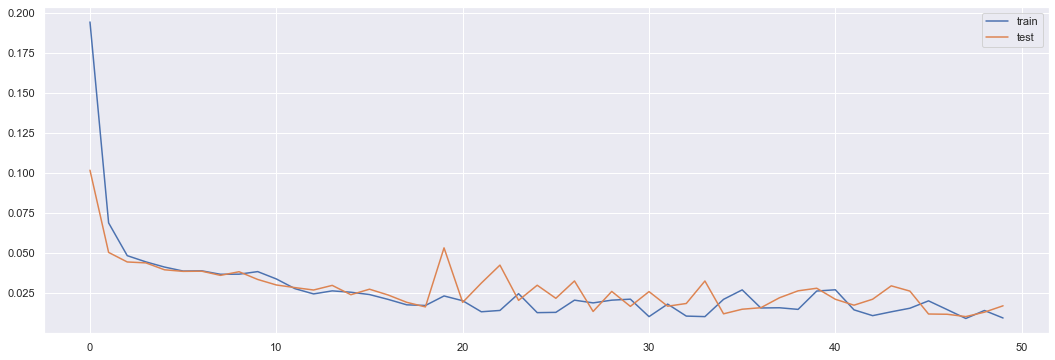

In [247]:
#train model on Cook County
model_name = 'Cook, 5-year prediction'
pred_months = 12 * 5
scaledCook = scaleData(dfCook)
reframed = series_to_supervised(scaledCook, pred_months, 1)
train_X, train_y, test_X, test_y = split_reshapeData(reframed, training_months)
model, history = trainModel(train_X, train_y, test_X, test_y)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [248]:
predictModel(model, model_name, dfNueces, 'Nueces', pred_months)
predictModel(model, model_name, dfWayne, 'Wayne', pred_months)

Cook, 5-year prediction  -  Nueces Test RMSE: 0.056
Cook, 5-year prediction  -  Wayne Test RMSE: 0.036
